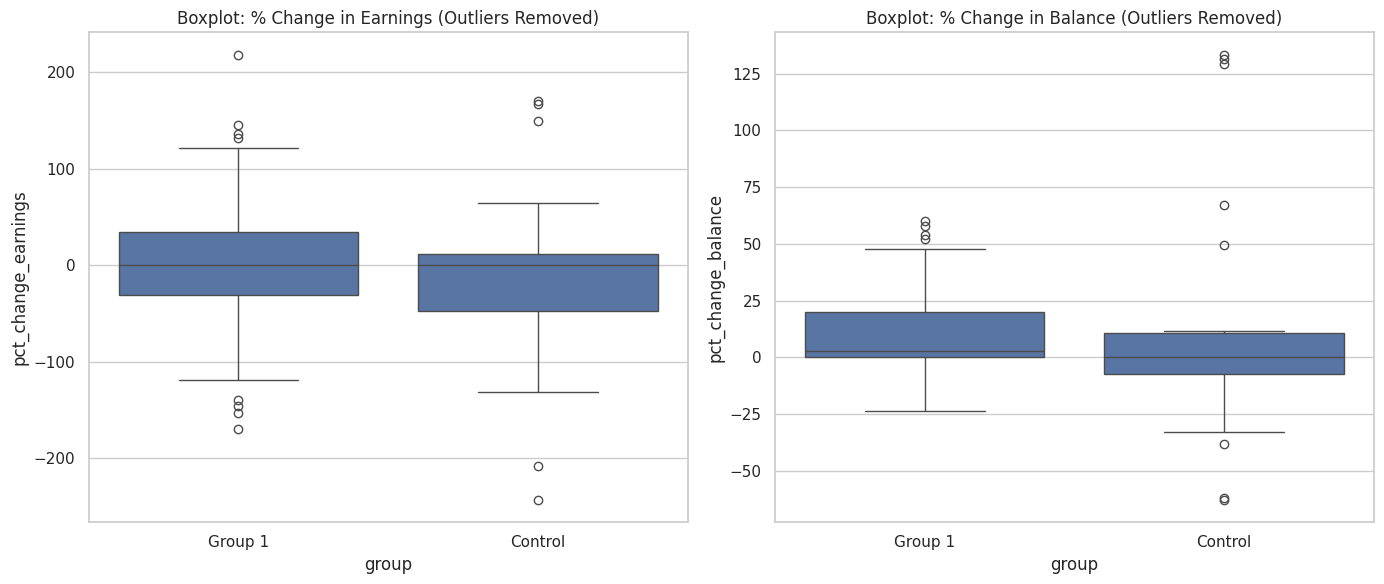

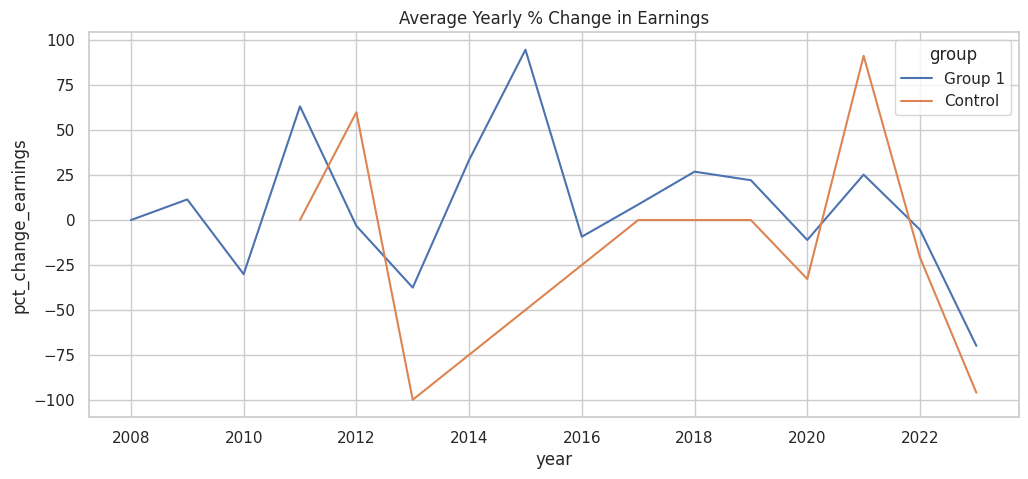

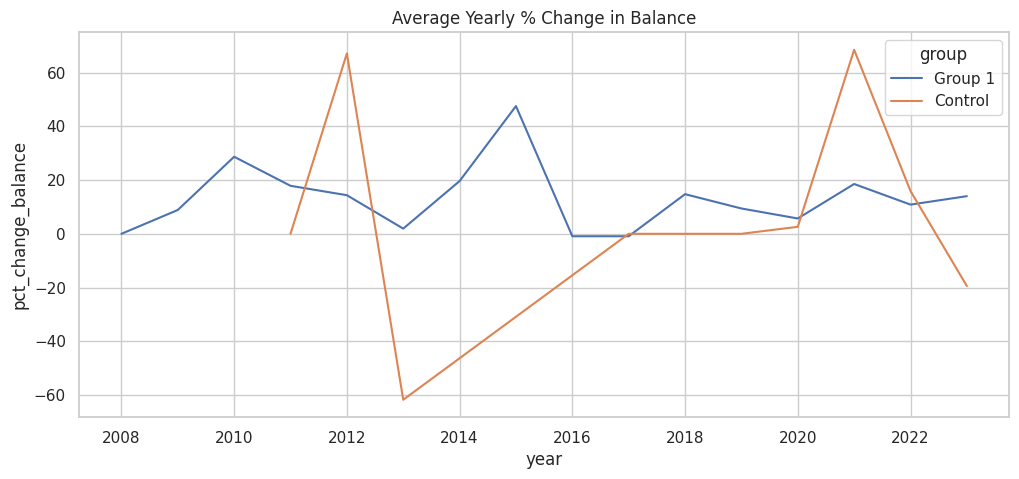

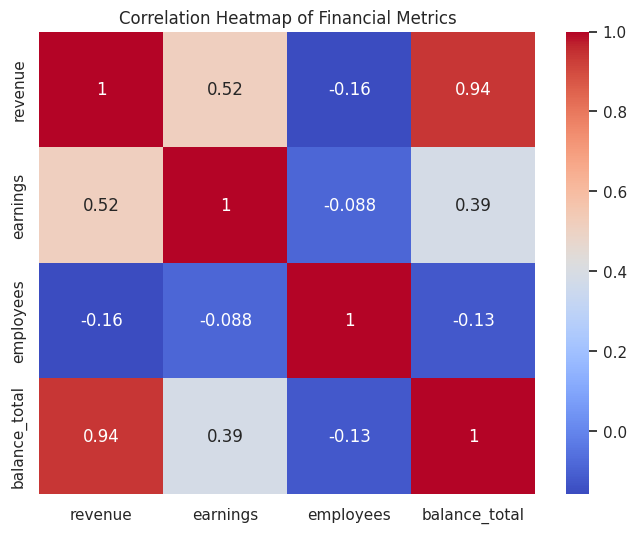

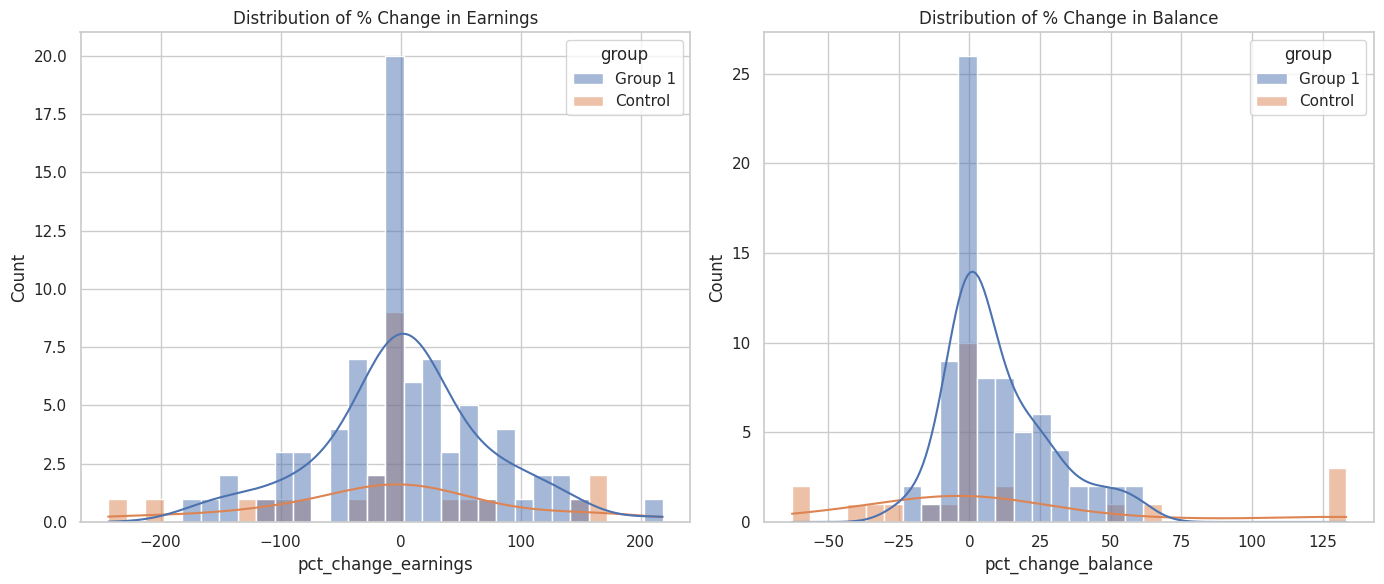

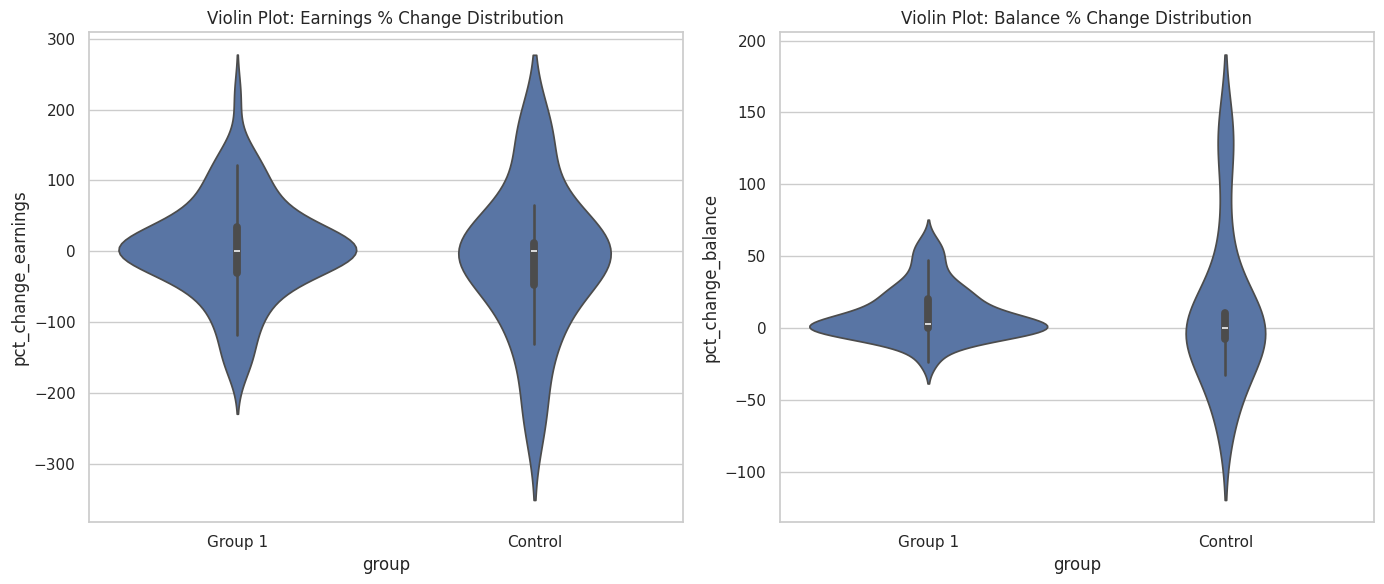

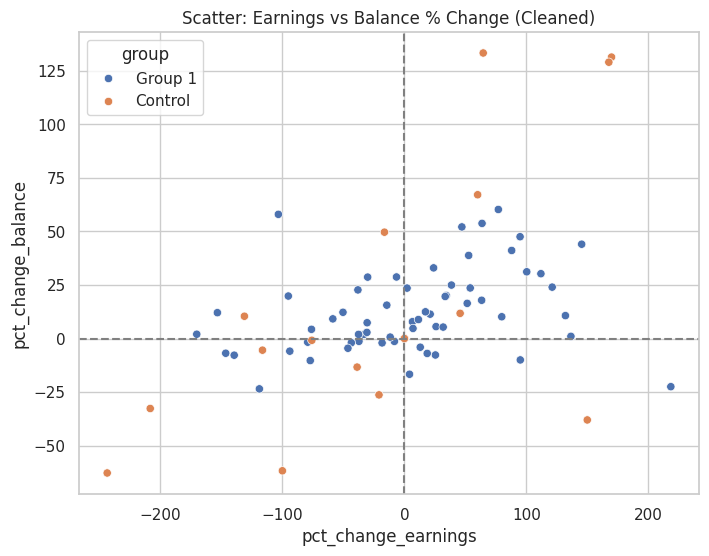

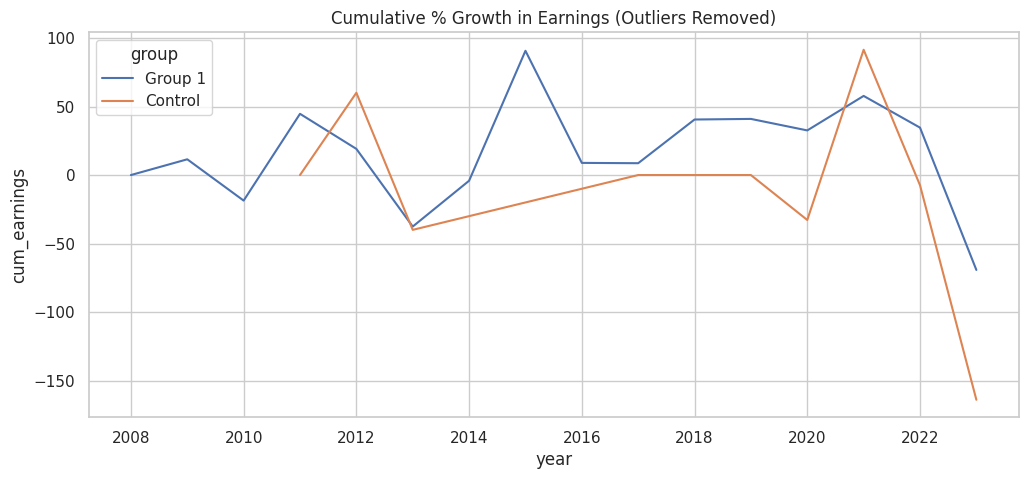

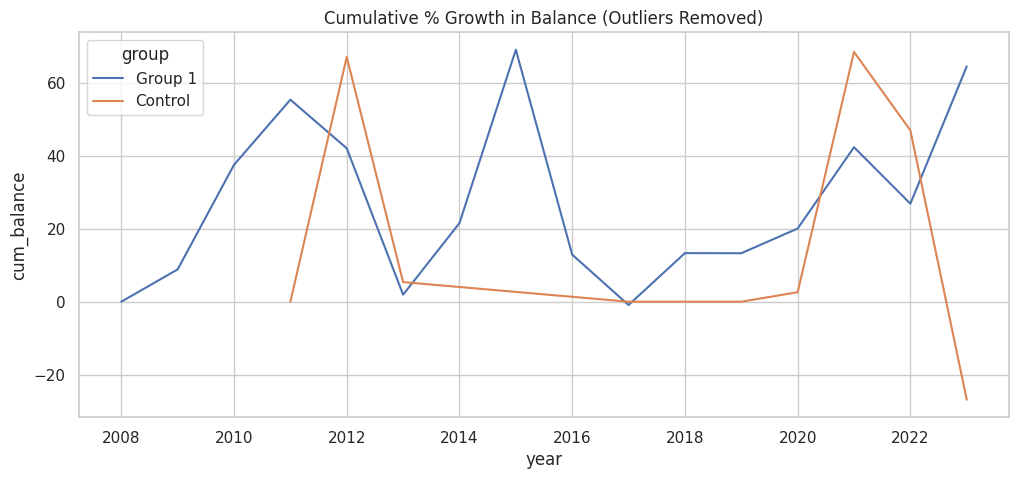

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel file
xls = pd.ExcelFile("data.xlsx")
df = xls.parse('Sheet1')

# Fill missing values and preprocess
numerical_cols = ['revenue', 'earnings', 'employees', 'balance_total']
df[numerical_cols] = df[numerical_cols].fillna(0)
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# Classify into Group 1 and Control
company_counts = df['name'].value_counts()
group_1_names = company_counts[company_counts >= 7].index.tolist()
control_names = company_counts[company_counts <= 5].index.tolist()

group_1_df = df[df['name'].isin(group_1_names)].copy()
control_df = df[df['name'].isin(control_names)].copy()

# Compute percentage changes
def calculate_percentage_changes(df):
    df = df.sort_values(by=['name', 'year'])
    df['pct_change_earnings'] = df.groupby('name')['earnings'].pct_change().fillna(0) * 100
    df['pct_change_balance'] = df.groupby('name')['balance_total'].pct_change().fillna(0) * 100
    return df

group_1_changes = calculate_percentage_changes(group_1_df)
control_changes = calculate_percentage_changes(control_df)

# Remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

group_1_clean = remove_outliers_iqr(group_1_changes, ['pct_change_earnings', 'pct_change_balance'])
control_clean = remove_outliers_iqr(control_changes, ['pct_change_earnings', 'pct_change_balance'])

# Label groups
group_1_clean['group'] = 'Group 1'
control_clean['group'] = 'Control'
combined = pd.concat([group_1_clean, control_clean])

# Set style
sns.set(style="whitegrid")

# 1. Boxplots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=combined, x='group', y='pct_change_earnings')
plt.title("Boxplot: % Change in Earnings (Outliers Removed)")

plt.subplot(1, 2, 2)
sns.boxplot(data=combined, x='group', y='pct_change_balance')
plt.title("Boxplot: % Change in Balance (Outliers Removed)")
plt.tight_layout()
plt.show()

# 2. Line plots: Avg yearly % change
avg_yearly = combined.groupby(['year', 'group'])[['pct_change_earnings', 'pct_change_balance']].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_yearly, x='year', y='pct_change_earnings', hue='group')
plt.title("Average Yearly % Change in Earnings")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_yearly, x='year', y='pct_change_balance', hue='group')
plt.title("Average Yearly % Change in Balance")
plt.grid(True)
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(combined[['revenue', 'earnings', 'employees', 'balance_total']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Financial Metrics")
plt.show()

# 4. Histogram: Distribution of % changes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=combined, x='pct_change_earnings', hue='group', kde=True, bins=30)
plt.title("Distribution of % Change in Earnings")

plt.subplot(1, 2, 2)
sns.histplot(data=combined, x='pct_change_balance', hue='group', kde=True, bins=30)
plt.title("Distribution of % Change in Balance")
plt.tight_layout()
plt.show()

# 5. Violin plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=combined, x='group', y='pct_change_earnings')
plt.title("Violin Plot: Earnings % Change Distribution")

plt.subplot(1, 2, 2)
sns.violinplot(data=combined, x='group', y='pct_change_balance')
plt.title("Violin Plot: Balance % Change Distribution")
plt.tight_layout()
plt.show()

# 6. Scatter: Relationship between earnings & balance
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined, x='pct_change_earnings', y='pct_change_balance', hue='group')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Scatter: Earnings vs Balance % Change (Cleaned)")
plt.grid(True)
plt.show()

# 7. Cumulative % growth
combined['cum_earnings'] = combined.groupby(['name'])['pct_change_earnings'].cumsum()
combined['cum_balance'] = combined.groupby(['name'])['pct_change_balance'].cumsum()

avg_cum = combined.groupby(['year', 'group'])[['cum_earnings', 'cum_balance']].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_cum, x='year', y='cum_earnings', hue='group')
plt.title("Cumulative % Growth in Earnings (Outliers Removed)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_cum, x='year', y='cum_balance', hue='group')
plt.title("Cumulative % Growth in Balance (Outliers Removed)")
plt.grid(True)
plt.show()


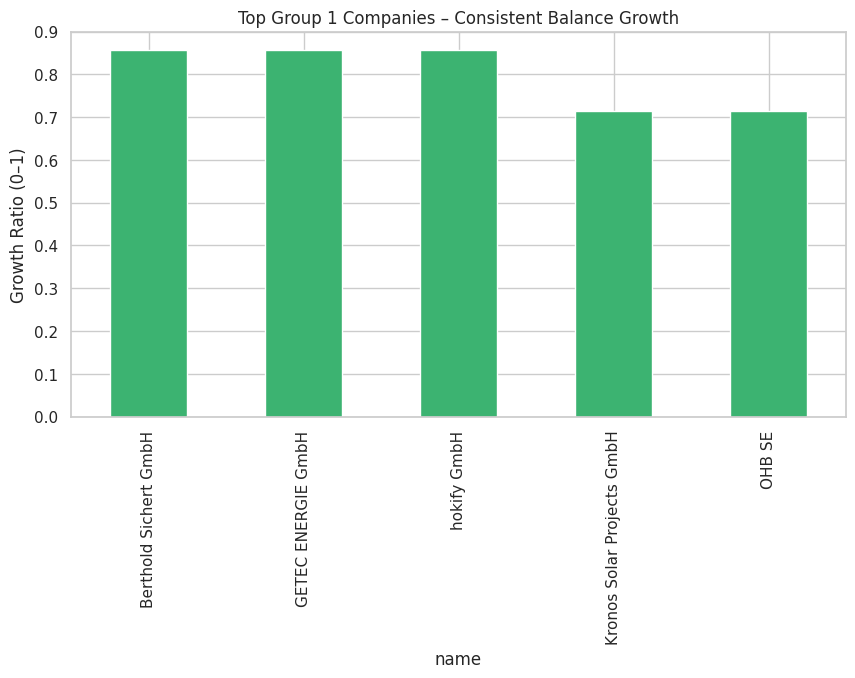

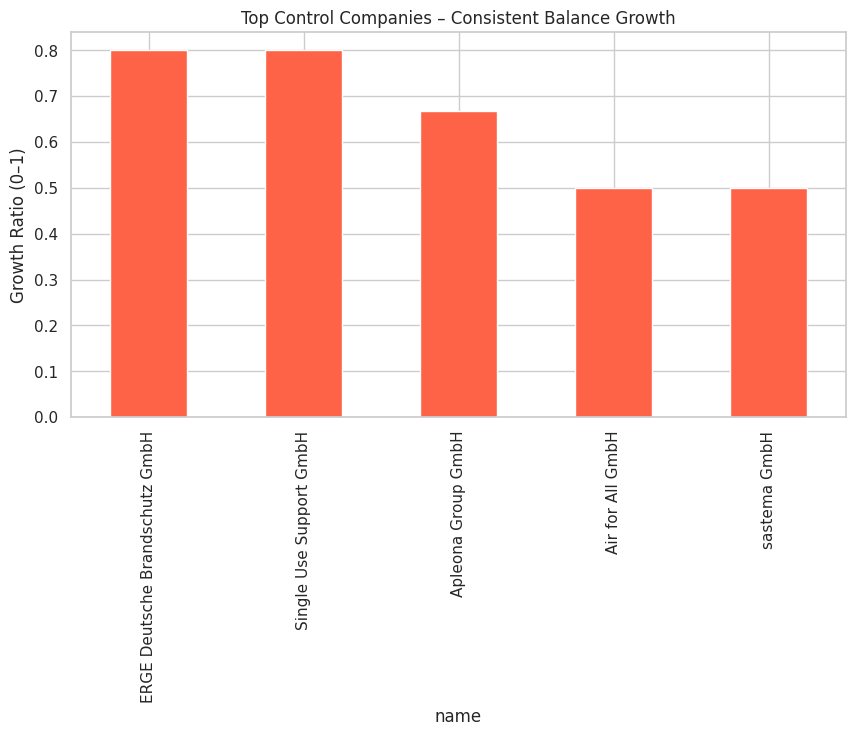

In [6]:

# 4. Bar Plot – Top Companies by Consistent Balance Growth
def identify_positive_trend(df, col):
    return df.groupby('name')[col].apply(lambda x: (x > 0).sum() / x.count())

top_group1 = identify_positive_trend(group_1_changes, 'pct_change_balance').sort_values(ascending=False).head(5)
top_control = identify_positive_trend(control_changes, 'pct_change_balance').sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 5))
top_group1.plot(kind='bar', color='mediumseagreen')
plt.title("Top Group 1 Companies – Consistent Balance Growth")
plt.ylabel("Growth Ratio (0–1)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
top_control.plot(kind='bar', color='tomato')
plt.title("Top Control Companies – Consistent Balance Growth")
plt.ylabel("Growth Ratio (0–1)")
plt.grid(True)
plt.show()